In [69]:
# import your code
from encoder import encode, header_bits
from decoder import decode
import numpy as np
import matplotlib.pyplot as plt
import operator

from cued_sf2_lab.familiarisation import load_mat_img, plot_image

from simple_lbt_functions import *

from cued_sf2_lab.laplacian_pyramid import quantise
from cued_sf2_lab.laplacian_pyramid import bpp


from scipy.optimize import minimize

from cued_sf2_lab.dct import * #regroup, regroup_inverse


Forward 8 x 8 DCT
Quantising to step size of 40
Generating huffcode and ehuf using default tables
Coding rows
Generating huffcode and ehuf using custom tables
Coding rows (second pass)
Bits for coded image = 31423
Bits for huffman table = 1424
Bits: 31423
1424
Generating huffcode and ehuf using custom tables
Decoding rows
Inverse quantising to step size of 40.0
Inverse 8 x 8 DCT

0.0 256.0
RMS = 10.94438532128862


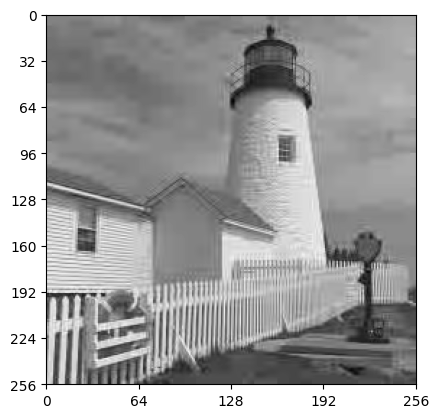

In [70]:
# Test encoder/decoder here
X, _ = load_mat_img('lighthouse.mat', img_info='X')
X = X - 128.0

#encode
step = 40
vlc, header = encode(X,jpeg_quant_size = step)
bits = vlc[:,1].sum()
print(f"Bits: {bits}")
print(header_bits(header))

#decode
Z = decode(vlc, header)
print(np.min(Z), np.max(Z)) # min max of Z
#print(Z[::64,::64].astype(int)) # typical numbers

fig, ax = plt.subplots()
plot_image(Z)

print(f"RMS = {np.std(X-Z)}")



In [71]:
step = 17

Y = lbt(X, N=8, s=1.31)
Y = quantise(Y, step, step)
Z = ilbt(Y, N=8, s=1.31)
print(f"RMS lbt once = {np.std(Z-X)}")
print(f"Bits needed = {bpp(Y)*Y.size}")


Y = lbt(X, N=8, s=1.31)
Y = lbt(Y, N=8, s=1.31)
Y = quantise(Y, step, step)
Z = ilbt(Y, N=8, s=1.31)
Z = ilbt(Z, N=8, s=1.31)
print(f"RMS lbt twice = {np.std(Z-X)}")
print(f"Bits needed = {bpp(Y)*Y.size}")

RMS lbt once = 5.052939654353368
Bits needed = 77052.37736234156
RMS lbt twice = 6.123378088560233
Bits needed = 215196.4963282172


In [72]:
# Testing regroup and regroup inverse

step = 17
N = 8

Y = lbt(X, N=8, s=1.31)
Y = quantise(Y, step, step)
#Yr = regroup(Yq,N)
#Yy = regroup(Yr,N)

print(Y[::64,::64])


m, n = Y.shape
N_m, N_n = N, N
Y = Y.reshape(m // N_m, N_m, n // N_n, N_n)  # subdivide the axes
Y = Y.transpose((1, 0, 3, 2))                # permute them
Y = Y.reshape(m, n)                          # and recombine

Y = Y.reshape(N_m, m // N_m, N_n, n // N_n)  # subdivide the axes
Y = Y.transpose((1, 0, 3, 2))                # permute them
Y = Y.reshape(m, n)                          # and recombine

print(Y[::64,::64])

# Reshape successful

[[ -76.5  -76.5  -25.5    0. ]
 [  42.5 -195.5 -212.5  246.5]
 [ 280.5 -195.5 -314.5   59.5]
 [-212.5  314.5  433.5  314.5]]
[[ -76.5  -76.5  -25.5    0. ]
 [  42.5 -195.5 -212.5  246.5]
 [ 280.5 -195.5 -314.5   59.5]
 [-212.5  314.5  433.5  314.5]]


In [73]:
step = 17

Y = lbt(X, N=8, s=1.31)
Y = quantise(Y, step, step)
Z = ilbt(Y, N=8, s=1.31)
print(f"RMS lbt once = {np.std(Z-X)}")
print(f"Bits needed = {bpp(Y)*Y.size}")


Y = lbt(X, N=8, s=1.31)

m, n = Y.shape
N_m, N_n = N, N
#print(Y[::32,::32].astype(int))
Y = Y.reshape(m // N_m, N_m, n // N_n, N_n)  # subdivide the axes
Y = Y.transpose((1, 0, 3, 2))                # permute them
Y = Y.reshape(m, n)                          # and recombine

Y = lbt(Y, N=8, s=1.31)
Y = quantise(Y, step, step)
Z = ilbt(Y, N=8, s=1.31)

Z = Z.reshape(N_m, m // N_m, N_n, n // N_n)  # subdivide the axes
Z = Z.transpose((1, 0, 3, 2))                # permute them
Z = Z.reshape(m, n)                          # and recombine

Z = ilbt(Z, N=8, s=1.31)

print(f"RMS lbt twice with regroup = {np.std(Z-X)}")
print(f"Bits needed = {bpp(Y)*Y.size}")




RMS lbt once = 5.052939654353368
Bits needed = 77052.37736234156
RMS lbt twice with regroup = 5.990626360552599
Bits needed = 101320.1826242938


RMS dct once = 5.268842305516852
Bits needed = 77600.44592300922
[[ -42.5  -42.5    0.     0.     0.     0.     0.     0. ]
 [  25.5  -76.5 -195.5   93.5    0.     0.    59.5    0. ]
 [  42.5  -76.5 -144.5   59.5    0.     0.     0.     0. ]
 [-195.5  161.5  229.5  144.5    0.    25.5  -59.5    0. ]
 [   0.     0.     0.     0.     0.     0.     0.     0. ]
 [   0.     0.   -42.5    0.     0.     0.   -42.5    0. ]
 [   0.     0.     0.     0.     0.     0.     0.     0. ]
 [ 195.5    0.     0.     0.     0.     0.     0.     0. ]]
RMS dct twice with regroup = 5.098427413633763
Bits needed = 183755.28004636787


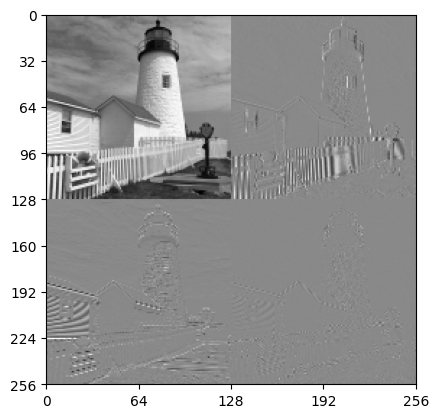

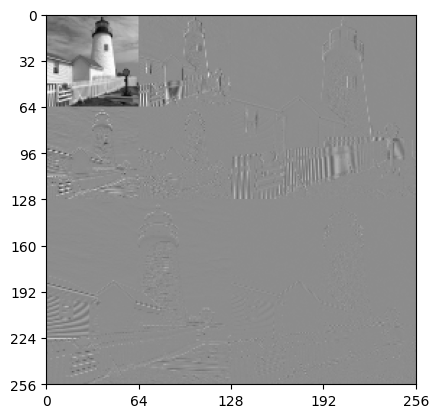

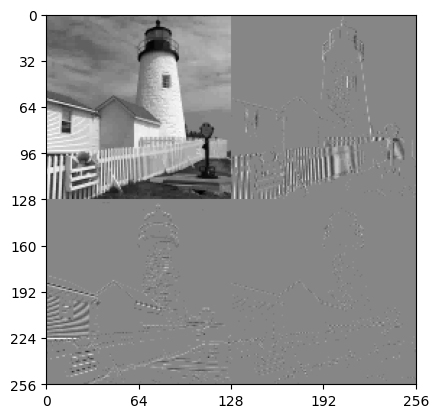

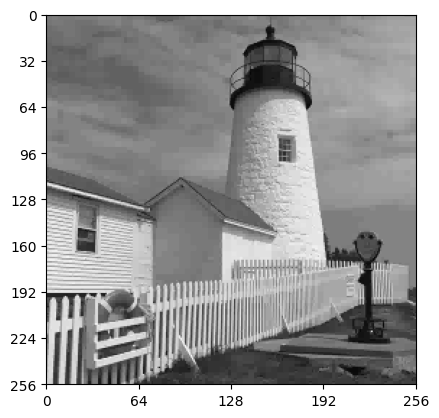

In [74]:
# Now I get what I have to do lmao

step = 17

Y = dct(X, N=8)
Y = quantise(Y, step, step)
Z = idct(Y, N=8)
print(f"RMS dct once = {np.std(Z-X)}")
print(f"Bits needed = {bpp(Y)*Y.size}")



N = 2

step = 17

Y = dct(X, N)

m, n = Y.shape
N_m, N_n = N, N
#print(Y[::32,::32].astype(int))
Y = Y.reshape(m // N_m, N_m, n // N_n, N_n)  # subdivide the axes
Y = Y.transpose((1, 0, 3, 2))                # permute them
Y = Y.reshape(m, n)                          # and recombine

fig,ax = plt.subplots()
plot_image(Y)

Y[:128,:128] = dct(Y[:128,:128], N)

Yr = Y.copy()
Yr[:128,:128] = regroup(Y[:128,:128], N)
fig,ax = plt.subplots()
plot_image(Yr)

Y = quantise(Y, step, step)
print(Y[::32,::32])
Z = Y
Z[:128,:128] = idct(Y[:128,:128], N)

fig,ax = plt.subplots()
plot_image(Z)

m, n = Y.shape
N_m, N_n = N, N
Z = Z.reshape(N_m, m // N_m, N_n, n // N_n)  # subdivide the axes
Z = Z.transpose((1, 0, 3, 2))                # permute them
Z = Z.reshape(m, n)                          # and recombine

Z = idct(Z, N=2)

fig,ax = plt.subplots()
plot_image(Z)

print(f"RMS dct twice with regroup = {np.std(Z-X)}")
print(f"Bits needed = {bpp(Y)*Y.size}")




In [75]:
def ipot2(Zp, N, s = 1):
    m = Zp.shape[0]
    t = np.s_[N//2:-N//2]
    pf,pr = pot_ii(N,s)
    cn = dct_ii(N)
    Z = Zp
    Z2 = Zp
    Z = colxfm(Z[:,t].T,pr.T).T
    Z = colxfm(Z[t,:],pr.T)
    for i in range(m-N):
        for j in range(m-N):
            Z2[int(i+N/2),int(j+N/2)] = Z[i,j]
    return Z2

def pot2(X, N, s = 1):
    m = X.shape[0]
    Xp = X.copy() # copy the non-transformed edges directly from X
    Xc = X.copy()

    t = np.s_[N//2:-N//2]
    pf,pr = pot_ii(N,s)
    cn = dct_ii(N)
    
    # First do XP =  PF * X
    Xp = colxfm(Xp[t,:],pf)
    Xp = colxfm(Xp[:,t].T, pf).T

    for i in range(m-N):
        for j in range(m-N):
            Xc[int(i+N/2),int(j+N/2)] = Xp[i,j]
    return Xc

RMS lbt once = 8.876573449371026
Bits needed = 37517.88548466447
[[-220.    0.    0.    0.    0.    0.    0.    0.]
 [  60.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.]]
RMS lbt twice with regroup = 8.56100384451066
Bits needed = 43499.7484029332


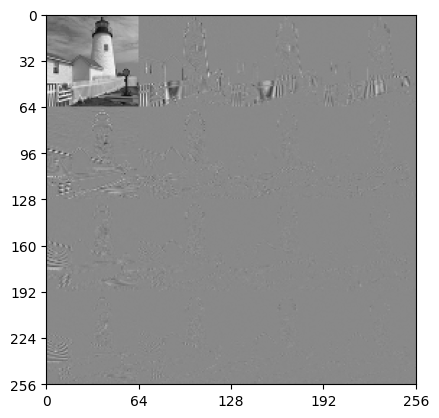

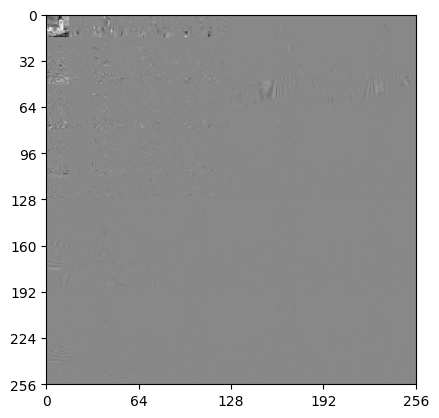

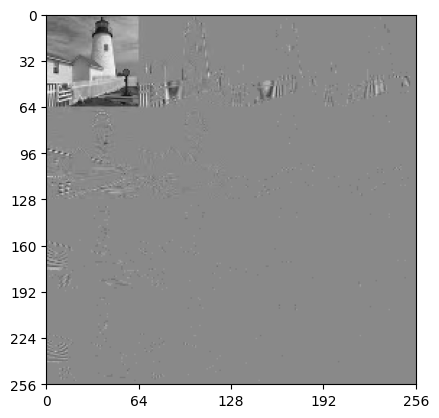

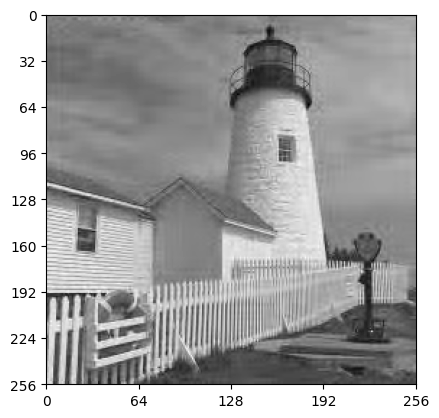

In [86]:
# Now I get what I have to do lmao

step = 40
s = 1.31
N = 8

Y = lbt(X, N, s)
Y = quantise(Y, step, step)
Z = ilbt(Y, N, s)
print(f"RMS lbt once = {np.std(Z-X)}")
print(f"Bits needed = {bpp(Y)*Y.size}")



N = 4
s = 1.31

step = 40

Y = pot2(X, N, s)
Y = dct(Y, N)

m, n = Y.shape
N_m, N_n = N, N
Y = regroup(Y, N)

fig,ax = plt.subplots()
plot_image(Y)

Y[:128,:128] = pot2(Y[:128,:128], N, s)
Y[:128,:128] = dct(Y[:128,:128], N)

Y[:128,:128] = regroup(Y[:128,:128], N)
fig,ax = plt.subplots()
plot_image(Y)

Y = quantise(Y, step, step)
print(Y[::32,::32])






Z = Y.copy()
Z2 = Z[:128,:128]
m, n = Z2.shape
N_m, N_n = N, N
Z2 = Z2.reshape(N_m, m // N_m, N_n, n // N_n)  # subdivide the axes
Z2 = Z2.transpose((1, 0, 3, 2))                # permute them
Z[:128,:128] = Z2.reshape(m, n)                          # and recombine

Z[:128,:128] = idct(Z[:128,:128], N)
Z[:128,:128] = ipot2(Z[:128,:128], N, s)


fig,ax = plt.subplots()
plot_image(Z)

m, n = Z.shape
N_m, N_n = N, N
Z = Z.reshape(N_m, m // N_m, N_n, n // N_n)  # subdivide the axes
Z = Z.transpose((1, 0, 3, 2))                # permute them
Z = Z.reshape(m, n)                          # and recombine
#Z = regroup(Z, N)


Z = idct(Z, N)
Z = ipot2(Z, N, s)


fig,ax = plt.subplots()
plot_image(Z)

print(f"RMS lbt twice with regroup = {np.std(Z-X)}")
print(f"Bits needed = {bpp(Y)*Y.size}")




In [77]:
# Now I get what I have to do lmao
""" Error - pot is not variable length
step = 17

Y = lbt(X, N=8, s=1.31)
Y = quantise(Y, step, step)
Z = ilbt(Y, N=8, s=1.31)
print(f"RMS lbt once = {np.std(Z-X)}")
print(f"Bits needed = {bpp(Y)*Y.size}")


Y = lbt(X, N=2, s=1.31)

m, n = Y.shape
N_m, N_n = 2, 2
#print(Y[::32,::32].astype(int))
Y = Y.reshape(m // N_m, N_m, n // N_n, N_n)  # subdivide the axes
Y = Y.transpose((1, 0, 3, 2))                # permute them
Y = Y.reshape(m, n)                          # and recombine

Y[:128,:128] = lbt(Y[:128,:128], N=2, s=1.31)
Y = quantise(Y, step, step)
Z = np.zeros_like(Y)
Z[:128,:128] = ilbt(Y[:128,:128], N=2, s=1.31)


m, n = Y.shape
N_m, N_n = 2, 2
Z = Z.reshape(N_m, m // N_m, N_n, n // N_n)  # subdivide the axes
Z = Z.transpose((1, 0, 3, 2))                # permute them
Z = Z.reshape(m, n)                          # and recombine

Z = ilbt(Z, N=2, s=1.31)

print(f"RMS lbt twice with regroup = {np.std(Z-X)}")
print(f"Bits needed = {bpp(Y)*Y.size}")


"""

' Error - pot is not variable length\nstep = 17\n\nY = lbt(X, N=8, s=1.31)\nY = quantise(Y, step, step)\nZ = ilbt(Y, N=8, s=1.31)\nprint(f"RMS lbt once = {np.std(Z-X)}")\nprint(f"Bits needed = {bpp(Y)*Y.size}")\n\n\nY = lbt(X, N=2, s=1.31)\n\nm, n = Y.shape\nN_m, N_n = 2, 2\n#print(Y[::32,::32].astype(int))\nY = Y.reshape(m // N_m, N_m, n // N_n, N_n)  # subdivide the axes\nY = Y.transpose((1, 0, 3, 2))                # permute them\nY = Y.reshape(m, n)                          # and recombine\n\nY[:128,:128] = lbt(Y[:128,:128], N=2, s=1.31)\nY = quantise(Y, step, step)\nZ = np.zeros_like(Y)\nZ[:128,:128] = ilbt(Y[:128,:128], N=2, s=1.31)\n\n\nm, n = Y.shape\nN_m, N_n = 2, 2\nZ = Z.reshape(N_m, m // N_m, N_n, n // N_n)  # subdivide the axes\nZ = Z.transpose((1, 0, 3, 2))                # permute them\nZ = Z.reshape(m, n)                          # and recombine\n\nZ = ilbt(Z, N=2, s=1.31)\n\nprint(f"RMS lbt twice with regroup = {np.std(Z-X)}")\nprint(f"Bits needed = {bpp(Y)*Y.size}")\n

# So I can hide this:

In [78]:
from typing import Tuple, NamedTuple, Optional

import numpy as np
from cued_sf2_lab.laplacian_pyramid import quant1, quant2
from cued_sf2_lab.dct import dct_ii, colxfm, regroup
from cued_sf2_lab.bitword import bitword


class HuffmanTable(NamedTuple):
    """A huffman table stored in sorted order
    
    Attributes:
        bits: The number of values per bit level, shape ``(16,)``.
        huffval: The codes sorted by bit length, shape ``(162,)``.
    """
    bits: np.ndarray
    huffval: np.ndarray

    @property
    def codes(self) -> np.ndarray:
        """ Produce an array of codewords corresponding to the requested bit lengths"""
        ncodes = len(self.huffval)
        if np.sum(self.bits) != ncodes:
            raise ValueError("bits and huffvals disagree")

        # Generate huffman size table (JPEG fig C1, p78):
        k = 0
        huffsize = np.zeros(ncodes, dtype=int)
        for i, b in enumerate(self.bits):
            huffsize[k:k+b] = i + 1
            k += b

        huffcode = np.zeros(ncodes, dtype=int)
        code = 0
        si = huffsize[0]

        # Generate huffman code table (JPEG fig C2, p79)
        for k in range(ncodes):
            while huffsize[k] > si:
                code = code * 2
                si += 1
            huffcode[k] = code
            code += 1

        huff_bitwords = np.zeros(ncodes, dtype=bitword.dtype)
        huff_bitwords['val'] = huffcode
        huff_bitwords['bits'] = huffsize
        return huff_bitwords

def HuffmanTable__new__(cls, bits, huffval):
    assert len(huffval) == sum(bits)
    return super(cls, HuffmanTable).__new__(cls, (bits, huffval))

HuffmanTable.__new__ = HuffmanTable__new__

In [83]:
def lbtenc_2layer(X: np.ndarray, qstep: float, N: int = 4, M: int = 4,
        opthuff: bool = False, dcbits: int = 8, log: bool = True, s: float = 1.0
        ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    '''
    Encodes the image in X to generate a variable length bit stream.

    Parameters:
        X: the input greyscale image
        qstep: the quantisation step to use in encoding
        N: the width of the DCT block (defaults to 8)
        M: the width of each block to be coded (defaults to N). Must be an
            integer multiple of N - if it is larger, individual blocks are
            regrouped.
        opthuff: if true, the Huffman table is optimised based on the data in X
        dcbits: the number of bits to use to encode the DC coefficients
            of the DCT.

    Returns:
        vlc: variable length output codes, where ``vlc[:,0]`` are the codes and
            ``vlc[:,1]`` the number of corresponding valid bits, so that
            ``sum(vlc[:,1])`` gives the total number of bits in the image
        hufftab: optional outputs containing the Huffman encoding
            used in compression when `opthuff` is ``True``.
    '''

    if M % N != 0:
        raise ValueError('M must be an integer multiple of N!')

    # DCT on input image X.
    if log:
        print('Forward {} x {} DCT'.format(N, N))
    C8 = dct_ii(N)
    #Y = colxfm(colxfm(X, C8).T, C8).T ################################################################################################
    #Y = lbt(X, N, s) #############################################################

    Y = pot2(X, N, s)
    Y = dct(Y, N)

    m, n = Y.shape
    N_m, N_n = N, N
    Y = regroup(Y, N)

    Y[:128,:128] = pot2(Y[:128,:128], N, s)
    Y[:128,:128] = dct(Y[:128,:128], N)

    Y[:128,:128] = regroup(Y[:128,:128], N)

    M *= M
    N *= N

    # Quantise to integers.
    if log:
        print('Quantising to step size of {}'.format(qstep))
    Yq = quant1(Y, qstep, qstep).astype('int')

    # Generate zig-zag scan of AC coefs.
    scan = diagscan(M)

    # On the first pass use default huffman tables.
    if log:
        print('Generating huffcode and ehuf using default tables')
    dhufftab = huffdflt(1)  # Default tables.
    huffcode, ehuf = huffgen(dhufftab)

    # Generate run/ampl values and code them into vlc(:,1:2).
    # Also generate a histogram of code symbols.
    if log:
        print('Coding rows')
    sy = Yq.shape
    huffhist = np.zeros(16 ** 2)
    vlc = []
    for r in range(0, sy[0], M):
        for c in range(0, sy[1], M):
            yq = Yq[r:r+M,c:c+M]
            # Possibly regroup
            if M > N:
                yq = regroup(yq, N)
            yqflat = yq.flatten('F')
            # Encode DC coefficient first
            dccoef = yqflat[0] + 2 ** (dcbits-1)
            if dccoef not in range(2**dcbits):
                raise ValueError(
                    'DC coefficients too large for desired number of bits')
            vlc.append(np.array([[dccoef, dcbits]]))
            # Encode the other AC coefficients in scan order
            # huffenc() also updates huffhist.
            ra1 = runampl(yqflat[scan])
            vlc.append(huffenc(huffhist, ra1, ehuf))
    # (0, 2) array makes this work even if `vlc == []`
    vlc = np.concatenate([np.zeros((0, 2), dtype=np.intp)] + vlc)

    # Return here if the default tables are sufficient, otherwise repeat the
    # encoding process using the custom designed huffman tables.
    if not opthuff:
        if log:
            print('Bits for coded image = {}'.format(sum(vlc[:, 1])))
        return vlc, dhufftab

    # Design custom huffman tables.
    if log:
        print('Generating huffcode and ehuf using custom tables')
    dhufftab = huffdes(huffhist)
    huffcode, ehuf = huffgen(dhufftab)

    # Generate run/ampl values and code them into vlc(:,1:2).
    # Also generate a histogram of code symbols.
    if log:
        print('Coding rows (second pass)')
    huffhist = np.zeros(16 ** 2)
    vlc = []
    for r in range(0, sy[0], M):
        for c in range(0, sy[1], M):
            yq = Yq[r:r+M, c:c+M]
            # Possibly regroup
            if M > N:
                yq = regroup(yq, N)
            yqflat = yq.flatten('F')
            # Encode DC coefficient first
            dccoef = yqflat[0] + 2 ** (dcbits-1)
            vlc.append(np.array([[dccoef, dcbits]]))
            # Encode the other AC coefficients in scan order
            # huffenc() also updates huffhist.
            ra1 = runampl(yqflat[scan])
            vlc.append(huffenc(huffhist, ra1, ehuf))
    # (0, 2) array makes this work even if `vlc == []`
    vlc = np.concatenate([np.zeros((0, 2), dtype=np.intp)] + vlc)

    if log:
        print('Bits for coded image = {}'.format(sum(vlc[:, 1])))
        print('Bits for huffman table = {}'.format(
            (16 + max(dhufftab.huffval.shape))*8))

    return vlc, dhufftab


def lbtdec_2layer(vlc: np.ndarray, qstep: float, N: int = 4, M: int = 4,
        hufftab: Optional[HuffmanTable] = None,
        dcbits: int = 8, W: int = 256, H: int = 256, log: bool = True, s: float = 1
        ) -> np.ndarray:
    '''
    Decodes a (simplified) JPEG bit stream to an image

    Parameters:

        vlc: variable length output code from jpegenc
        qstep: quantisation step to use in decoding
        N: width of the DCT block (defaults to 8)
        M: width of each block to be coded (defaults to N). Must be an
            integer multiple of N - if it is larger, individual blocks are
            regrouped.
        hufftab: if supplied, these will be used in Huffman decoding
            of the data, otherwise default tables are used
        dcbits: the number of bits to use to decode the DC coefficients
            of the DCT
        W, H: the size of the image (defaults to 256 x 256)

    Returns:

        Z: the output greyscale image
    '''

    M_copy = M
    N_copy = N

    M *= M
    N *= N



    opthuff = (hufftab is not None)
    if M % N != 0:
        raise ValueError('M must be an integer multiple of N!')

    # Set up standard scan sequence
    scan = diagscan(M)

    if opthuff:
        if len(hufftab.bits.shape) != 1:
            raise ValueError('bits.shape must be (len(bits),)')
        if log:
            print('Generating huffcode and ehuf using custom tables')
    else:
        if log:
            print('Generating huffcode and ehuf using default tables')
        hufftab = huffdflt(1)
    # Define starting addresses of each new code length in huffcode.
    # 0-based indexing instead of 1
    huffstart = np.cumsum(np.block([0, hufftab.bits[:15]]))
    # Set up huffman coding arrays.
    huffcode, ehuf = huffgen(hufftab)

    # Define array of powers of 2 from 1 to 2^16.
    k = 2 ** np.arange(17)

    # For each block in the image:

    # Decode the dc coef (a fixed-length word)
    # Look for any 15/0 code words.
    # Choose alternate code words to be decoded (excluding 15/0 ones).
    # and mark these with vector t until the next 0/0 EOB code is found.
    # Decode all the t huffman codes, and the t+1 amplitude codes.

    eob = ehuf[0]
    run16 = ehuf[15 * 16]
    i = 0
    Zq = np.zeros((H, W))

    if log:
        print('Decoding rows')
    for r in range(0, H, M):
        for c in range(0, W, M):
            yq = np.zeros(M**2)

            # Decode DC coef - assume no of bits is correctly given in vlc table.
            cf = 0
            if vlc[i, 1] != dcbits:
                raise ValueError(
                    'The bits for the DC coefficient does not agree with vlc table')
            yq[cf] = vlc[i, 0] - 2 ** (dcbits-1)
            i += 1

            # Loop for each non-zero AC coef.
            while np.any(vlc[i] != eob):
                run = 0

                # Decode any runs of 16 zeros first.
                while np.all(vlc[i] == run16):
                    run += 16
                    i += 1

                # Decode run and size (in bits) of AC coef.
                start = huffstart[vlc[i, 1] - 1]
                res = hufftab.huffval[start + vlc[i, 0] - huffcode[start]]
                run += res // 16
                cf += run + 1
                si = res % 16
                i += 1

                # Decode amplitude of AC coef.
                if vlc[i, 1] != si:
                    raise ValueError(
                        'Problem with decoding .. you might be using the wrong hufftab table')
                ampl = vlc[i, 0]

                # Adjust ampl for negative coef (i.e. MSB = 0).
                thr = k[si - 1]
                yq[scan[cf-1]] = ampl - (ampl < thr) * (2 * thr - 1)

                i += 1

            # End-of-block detected, save block.
            i += 1

            yq = yq.reshape((M, M)).T

            # Possibly regroup yq
            if M > N:
                yq = regroup(yq, M//N)
            Zq[r:r+M, c:c+M] = yq

    if log:
        print('Inverse quantising to step size of {}'.format(qstep))

    Zi = quant2(Zq, qstep, qstep)

    if log:
        print('Inverse {} x {} DCT\n'.format(N, N))
    C8 = dct_ii(N)
    #Z = colxfm(colxfm(Zi.T, C8.T).T, C8.T) ###################################################################################################
    #Zq = ilbt(Zi, N, s) ############################################################

    M = M_copy
    N = N_copy


    Z = Y.copy()
    Z2 = Z[:128,:128]
    m, n = Z2.shape
    N_m, N_n = N, N
    Z2 = Z2.reshape(N_m, m // N_m, N_n, n // N_n)  # subdivide the axes
    Z2 = Z2.transpose((1, 0, 3, 2))                # permute them
    Z[:128,:128] = Z2.reshape(m, n)                          # and recombine

    Z[:128,:128] = idct(Z[:128,:128], N)
    Z[:128,:128] = ipot2(Z[:128,:128], N, s)

    m, n = Z.shape
    N_m, N_n = N, N
    Z = Z.reshape(N_m, m // N_m, N_n, n // N_n)  # subdivide the axes
    Z = Z.transpose((1, 0, 3, 2))                # permute them
    Z = Z.reshape(m, n)                          # and recombine
    #Z = regroup(Z, N)


    Z = idct(Z, N)
    Zq = ipot2(Z, N, s)



    z_max = np.max(Zq)
    z_min = np.min(Zq)
    Zq = Zq * 256/np.abs(z_max - z_min)
    Zq = Zq - np.min(Zq)
    return Zq

# Okay here's the test

In [84]:
# your code here
from cued_sf2_lab.jpeg import *

#X, cmaps_dict = load_mat_img(img='lighthouse.mat', img_info='X', cmap_info={'map', 'map2'})
#X = X - 128.0
lighthouse, _ = load_mat_img(img='lighthouse.mat', img_info='X')
X = lighthouse - 128.0

qstep = 40
vlc, hufftab = lbtenc_2layer(lighthouse, qstep, opthuff=True)


print(vlc[:,1].sum())

#print(dict(zip(hufftab.huffval, hufftab.codes)))|
print(hufftab.huffval)

Forward 4 x 4 DCT
Quantising to step size of 40
Generating huffcode and ehuf using default tables
Coding rows
Generating huffcode and ehuf using custom tables
Coding rows (second pass)
Bits for coded image = 40235
Bits for huffman table = 1424
40235
[240   1   2  17   0   3   6  18  33  49  65  81  34  50  97 113 129 145
 161   4   7  19  66  82  98 130 177 193 209 225 241   5  35 114 146 210
  20  51  67  83 162 178 194 226 242  99 115  36  52 131 147 163 195 211
  21  37  68  84 116   8   9  10  22  23  24  25  26  38  39  40  41  42
  53  54  55  56  57  58  69  70  71  72  73  74  85  86  87  88  89  90
 100 101 102 103 104 105 106 117 118 119 120 121 122 132 133 134 135 136
 137 138 148 149 150 151 152 153 154 164 165 166 167 168 169 170 179 180
 181 182 183 184 185 186 196 197 198 199 200 201 202 212 213 214 215 216
 217 218 227 228 229 230 231 232 233 234 243 244 245 246 247 248 249 250]


Generating huffcode and ehuf using custom tables
Decoding rows
Inverse quantising to step size of 40
Inverse 16 x 16 DCT

19.622410780619614
0.0 256.0


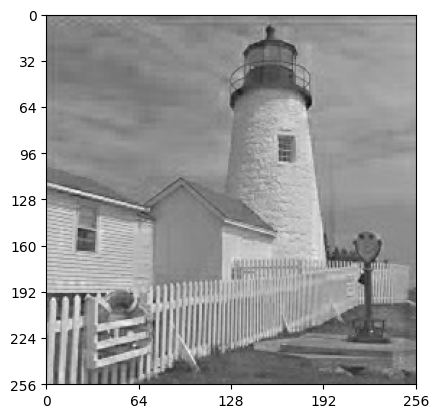

In [85]:
Z = lbtdec_2layer(vlc, qstep, hufftab = hufftab) # We don't need hufftab? what is this sorcery

fig, ax = plt.subplots()
plot_image(Z)

print(np.std(X-Z))
print(np.min(Z), np.max(Z)) # min max of Z

# NEED TO FIX N=4 vs N=16 problem in the encoder/decoder!!!!!!!!!!!


Forward 8 x 8 DCT
Quantising to step size of 40
Generating huffcode and ehuf using default tables
Coding rows
Generating huffcode and ehuf using custom tables
Coding rows (second pass)
Bits for coded image = 31423
Bits for huffman table = 1424
Bits: 31423
1424
Generating huffcode and ehuf using custom tables
Decoding rows
Inverse quantising to step size of 40.0
Inverse 8 x 8 DCT

0.0 256.0
RMS = 10.94438532128862


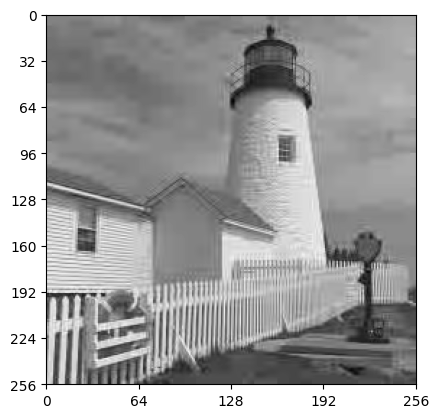

In [82]:
# Test encoder/decoder here
X, _ = load_mat_img('lighthouse.mat', img_info='X')
X = X - 128.0

#encode
step = 40
vlc, header = encode(X,jpeg_quant_size = step)
bits = vlc[:,1].sum()
print(f"Bits: {bits}")
print(header_bits(header))

#decode
Z = decode(vlc, header)
print(np.min(Z), np.max(Z)) # min max of Z
#print(Z[::64,::64].astype(int)) # typical numbers

fig, ax = plt.subplots()
plot_image(Z)

print(f"RMS = {np.std(X-Z)}")

